Import các thư viện cần thiết

In [102]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

Xây dựng dataframes, chuẩn hóa dữ liệu.

In [107]:
data_frames = []

for file in os.listdir('data'):
    if file.endswith('.csv'):
        file_path = os.path.join('data', file)
        df = pd.read_csv(file_path)
        df['file'] = file

        # Thay đổi string thành datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Thay đổi datetime thành ordinal (số nguyên)
    df['Date_Ordinal'] = df['Date'].map(lambda x: x.toordinal())

    # Sắp xếp dữ liệu theo ngày
    df = df.sort_values(by='Date_Ordinal')

    # Thêm cột High, Low của phiên tiếp theo
    df['High_Next'] = df['High'].shift(-1)
    df['Low_Next'] = df['Low'].shift(-1)

    # Xóa các dòng không có giá trị tương lai (Dòng cuối)
    df = df.dropna()

    data_frames.append(df)


Xây dựng mô hình hồi quy tuyến tính bằng thư viện Scikit-Learn

In [108]:
sets = []

for df in data_frames:
    # Phân chia tập data, label
    data = df[['Date_Ordinal', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    label = df[['High_Next', 'Low_Next']]

    # Phân chia tập train, test
    # Đặc điểm dữ liệu là theo thứ tự nên không thể shuffle
    X_train, X_test, Y_train, Y_test = train_test_split(data, label , test_size=0.2, random_state=42)

    sets.append((X_train, X_test, Y_train, Y_test))


In [109]:
# Hàm luyện mô hình
def linear_model(X_train, X_test, Y_train, Y_test):

    #Khởi tạo và huấn luyện mô hình
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Dự đoán các giá trị trên tập x_test
    Y_pred = model.predict(X_test)

    # Đánh giá mô hình bằng độ đo MAE và MSE
    mae_high = mean_absolute_error(Y_test['High_Next'], Y_pred[:, 0])
    mae_low = mean_absolute_error(Y_test['Low_Next'], Y_pred[:, 1])
    mse_high = mean_squared_error(Y_test['High_Next'], Y_pred[:, 0])
    mse_low = mean_squared_error(Y_test['Low_Next'], Y_pred[:, 1])

    return Y_pred, mae_high, mae_low, mse_high, mse_low

Huấn luyện mô hình và trực quan hóa mô hình.

In [110]:
# Huấn luyện mô hình
predictions = []
mae_high_set = []
mae_low_set = []
mse_high_set = []
mse_low_set = []

for set in sets:
    prediction, mae_high, mae_low, mse_high, mse_low = linear_model(set[0], set[1], set[2], set[3])
    predictions.append(prediction)
    mae_high_set.append(mae_high)
    mae_low_set.append(mae_low)
    mse_high_set.append(mse_high)
    mse_low_set.append(mse_low)




Cấu trúc của predictions
    10 phần từ trong predictions là của 10 tập hợp
        Mỗi phần tử là giá một ngày dự đoán
            2 phần tử lần lượt là high và low dự đoán: [25.75977333 23.28378705]

Trực quan hóa kết quả 

In [ ]:
# Xây dựng hàm trực quan hóa
def plot_high_predictions(X_test, prediction, Y_test, path, title="Dự đoán giá cổ phiếu"):
    plt.figure(figsize=(12, 6))

    #Scatter plot
    sns.lineplot(x=X_test['Date_Ordinal'], y=Y_test["High_Next"], color='blue', label='Giá cao nhất thực tế')
    sns.lineplot(x=X_test['Date_Ordinal'], y=prediction[:, 0], color='red', label='Giá cao nhất dự đoán')

    plt.xlabel('Ngày (Ordinal)')
    plt.ylabel('Giá cổ phiếu')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

def plot_low_predictions(X_test, prediction, Y_test, path, title="Dự đoán giá cổ phiếu"):
    plt.figure(figsize=(12, 6))

    #Scatter plot
    sns.lineplot(x=X_test['Date_Ordinal'], y=Y_test["Low_Next"], color='blue', label='Giá thấp nhất thực tế')
    sns.lineplot(x=X_test['Date_Ordinal'], y=prediction[:, 1], color='red', label='Giá thấp nhất dự đoán')

    plt.xlabel('Ngày (Ordinal)')
    plt.ylabel('Giá cổ phiếu')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

def plot_mae_mse(mae_high_set, mae_low_set, mse_high_set, mse_low_set, path):
    plt.figure(figsize=(12, 6))

    #Scatter plot
    sns.lineplot(x=X_test['Date_Ordinal'], y=Y_test["Low_Next"], color='blue', label='Giá thấp nhất thực tế')
    sns.lineplot(x=X_test['Date_Ordinal'], y=prediction[:, 1], color='red', label='Giá thấp nhất dự đoán')

    plt.xlabel('Ngày (Ordinal)')
    plt.ylabel('Giá cổ phiếu')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)


Trực quan hóa kết quả 

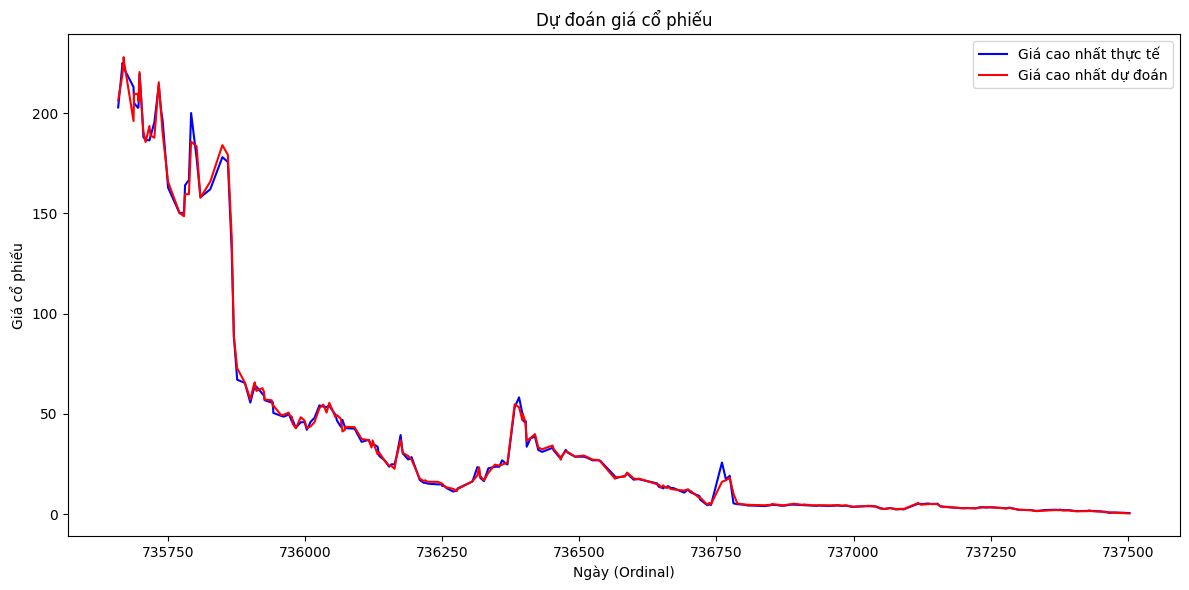

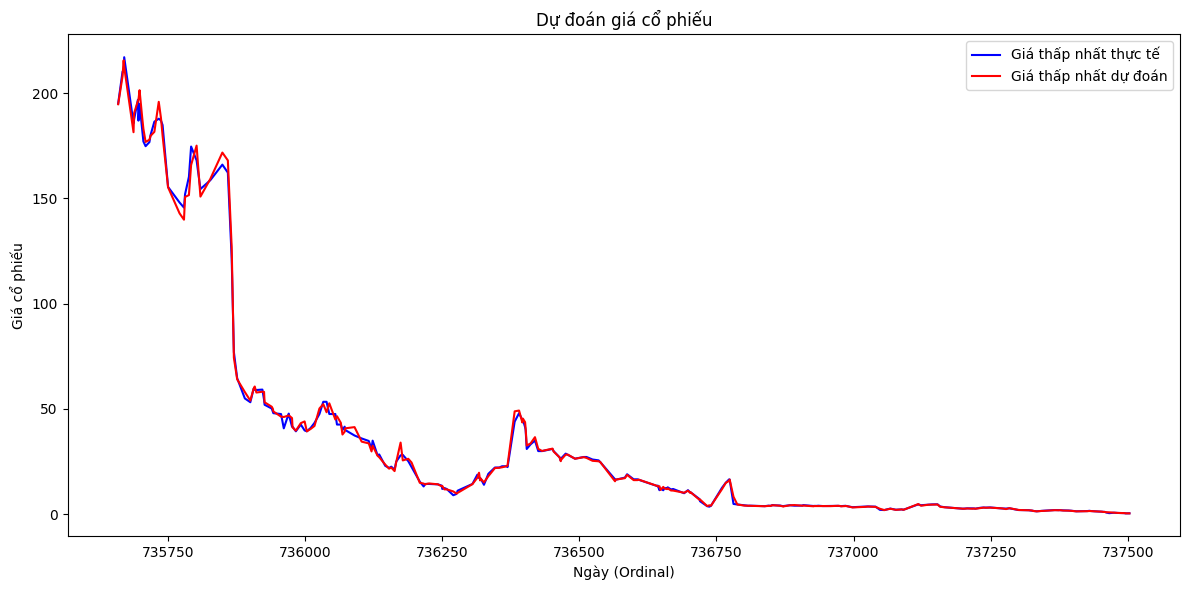

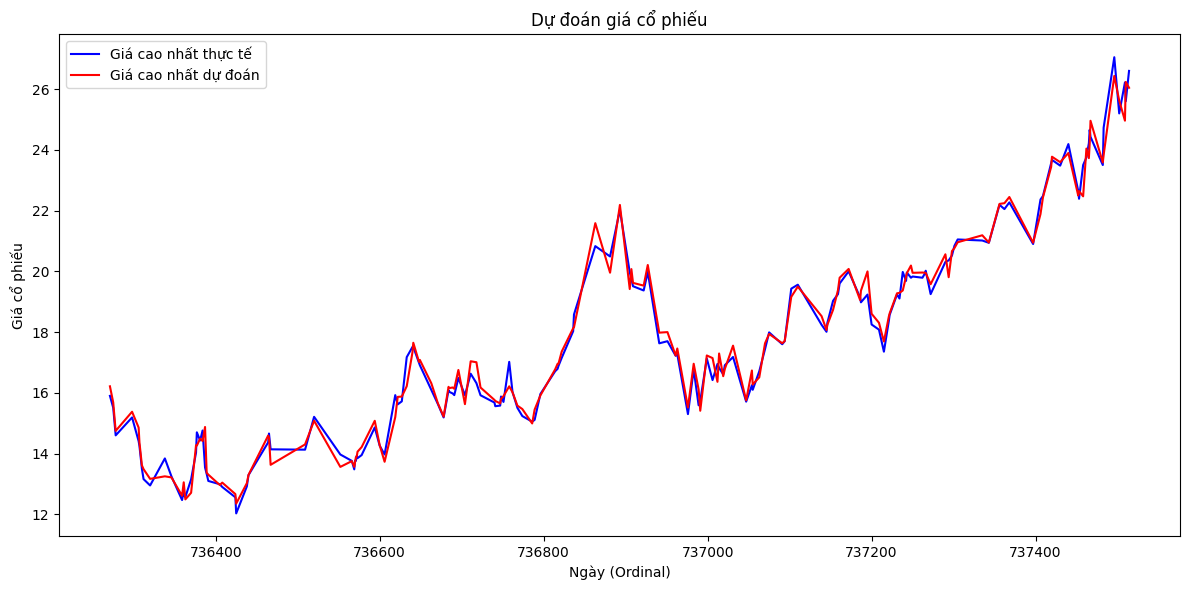

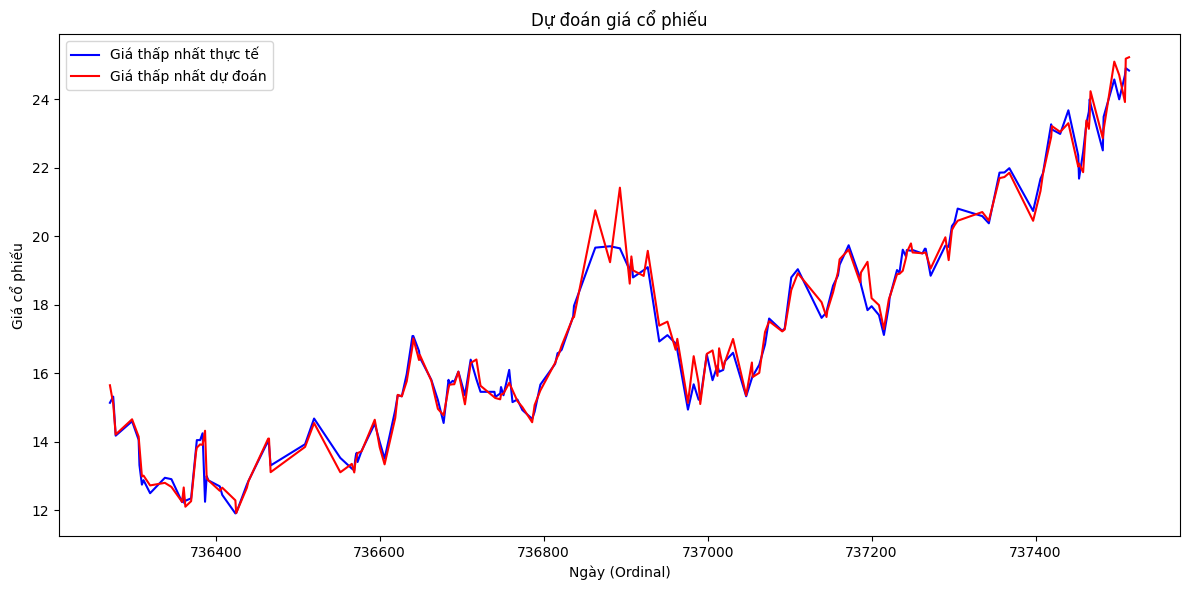

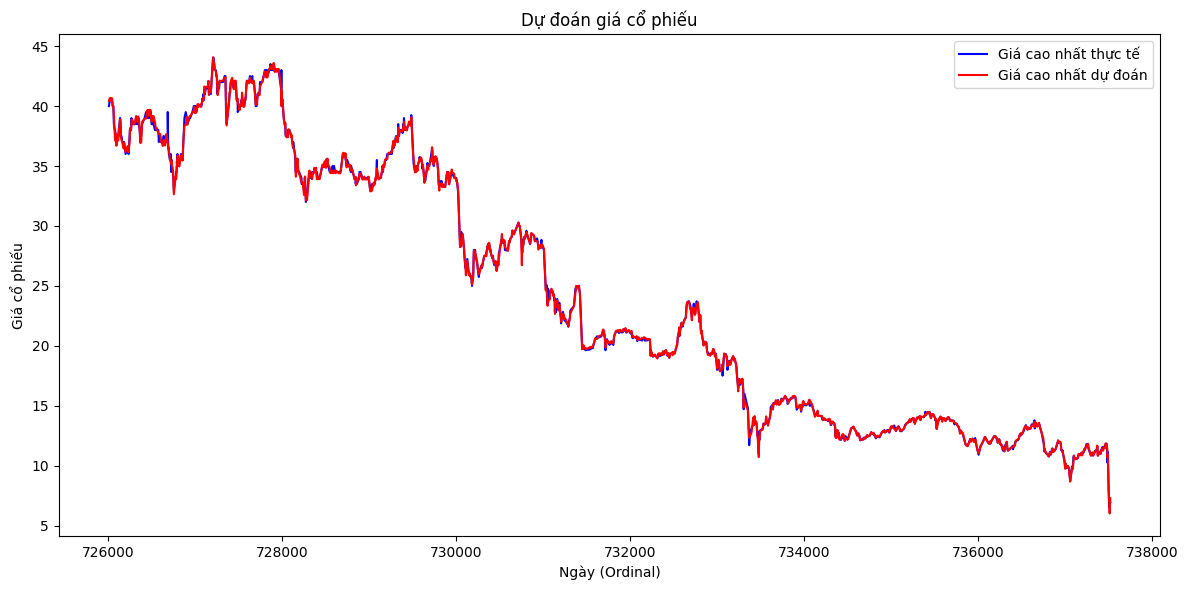

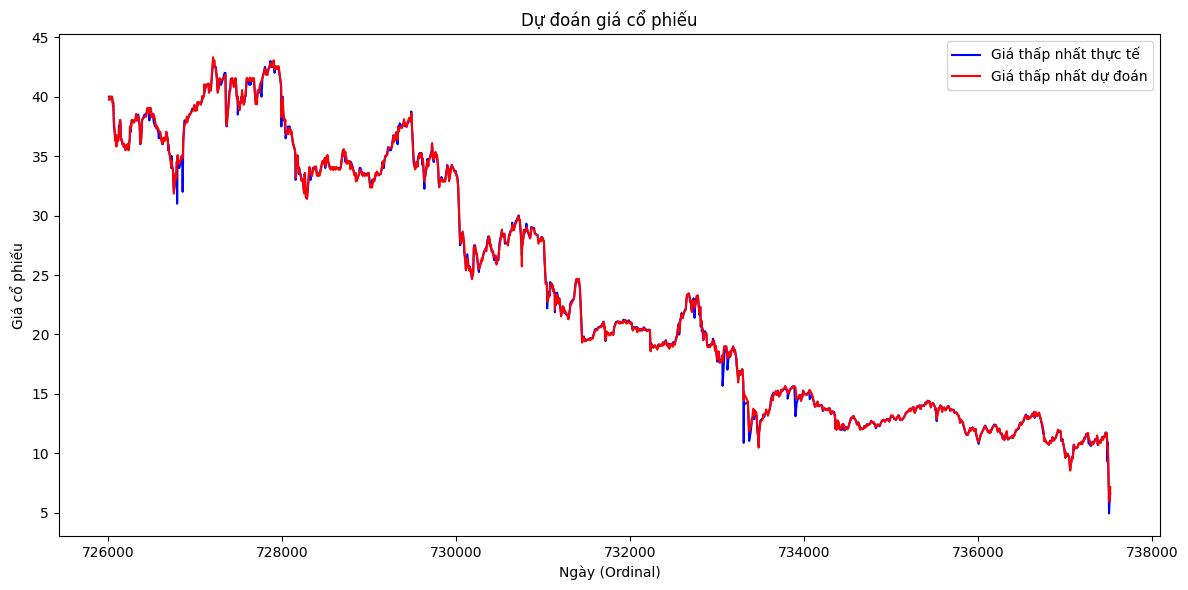

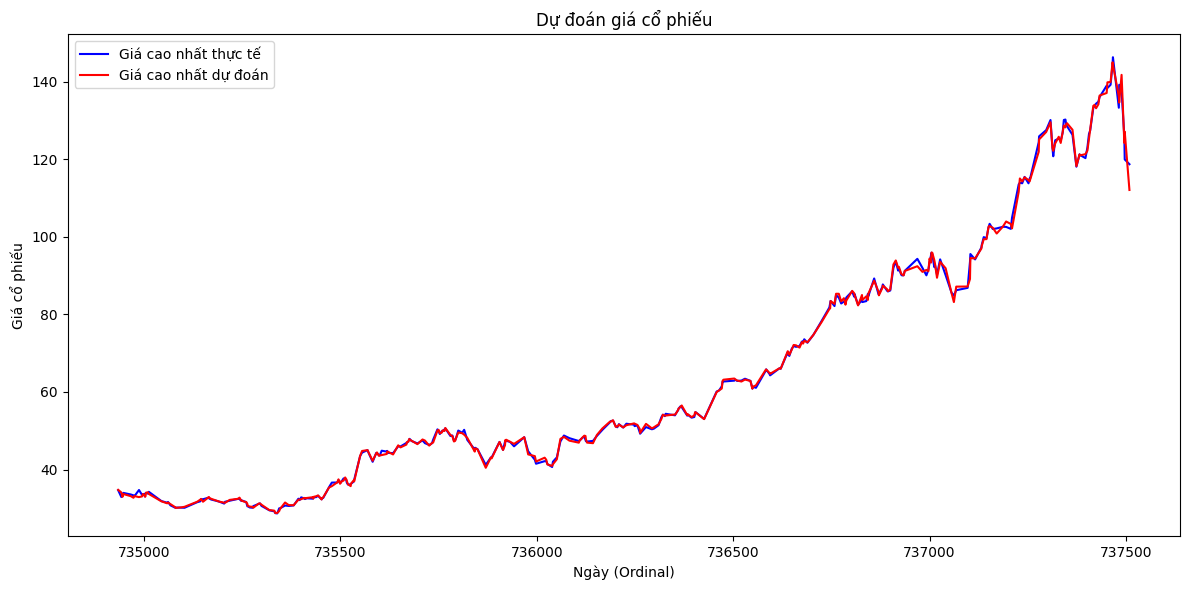

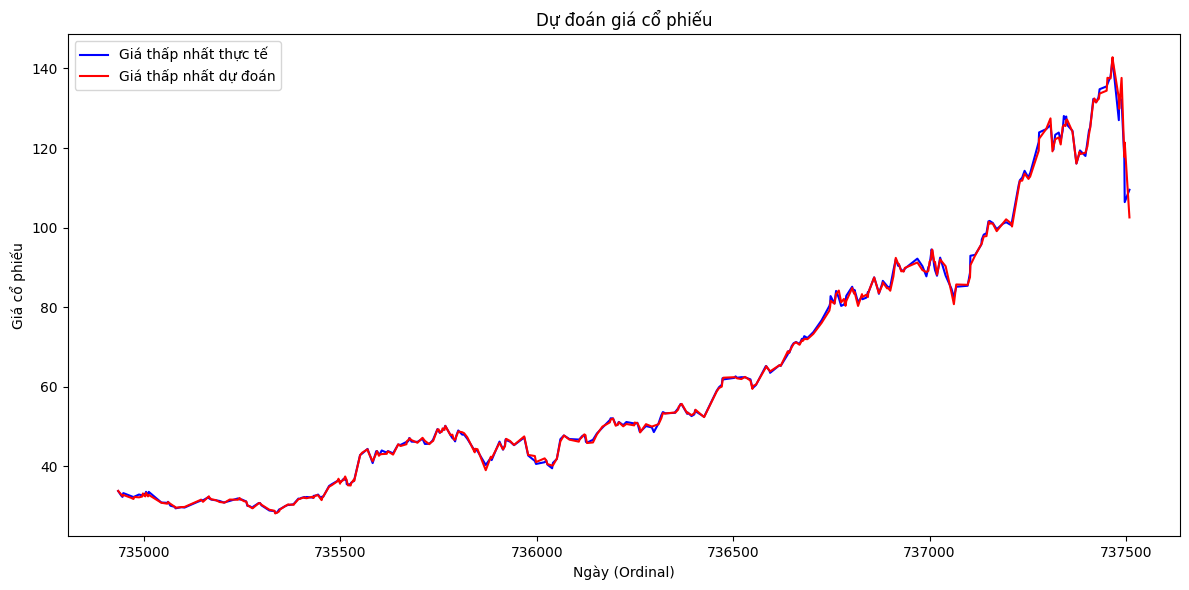

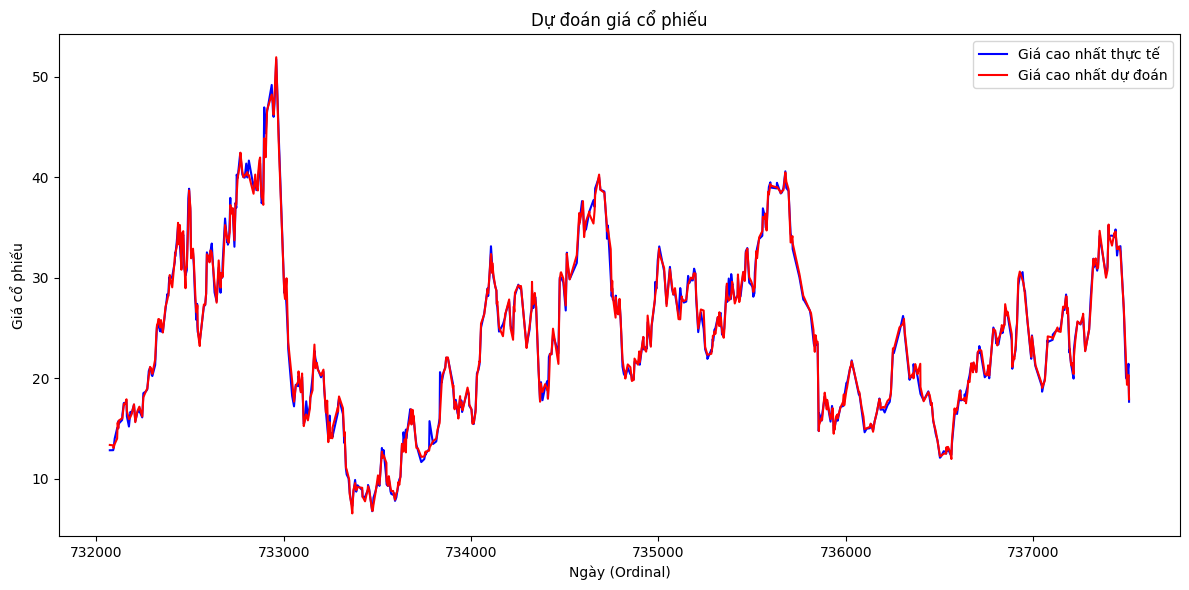

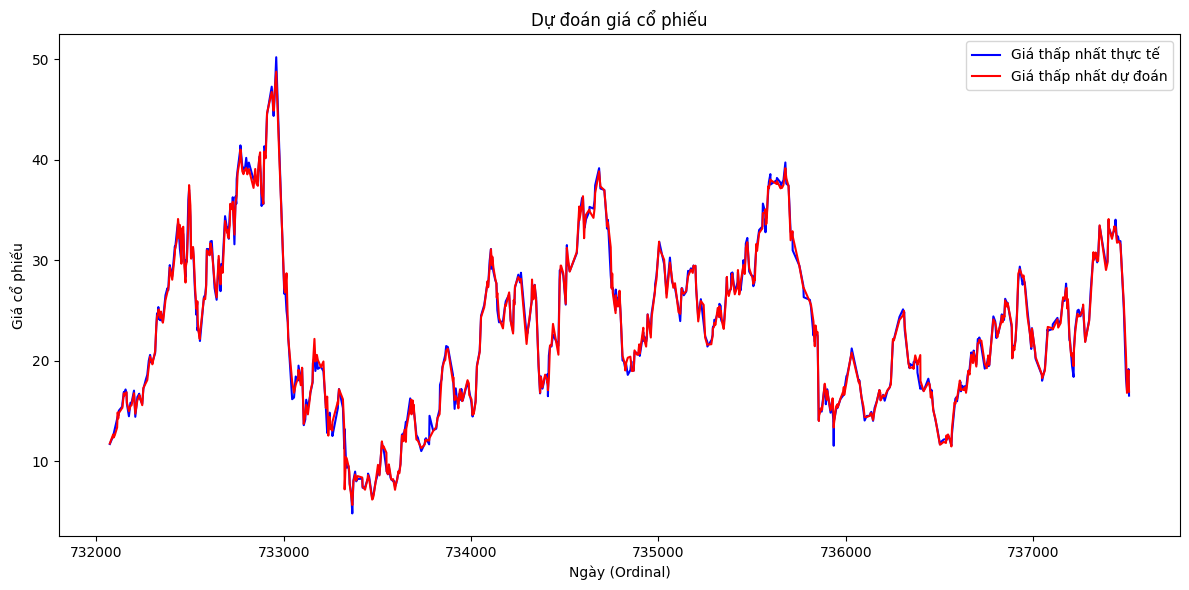

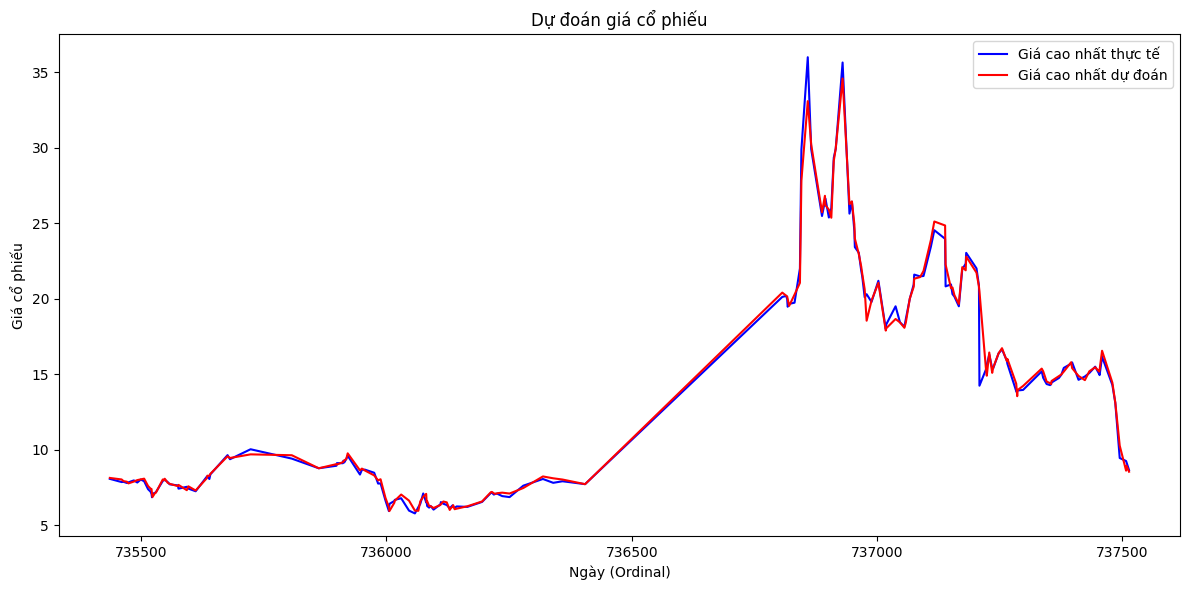

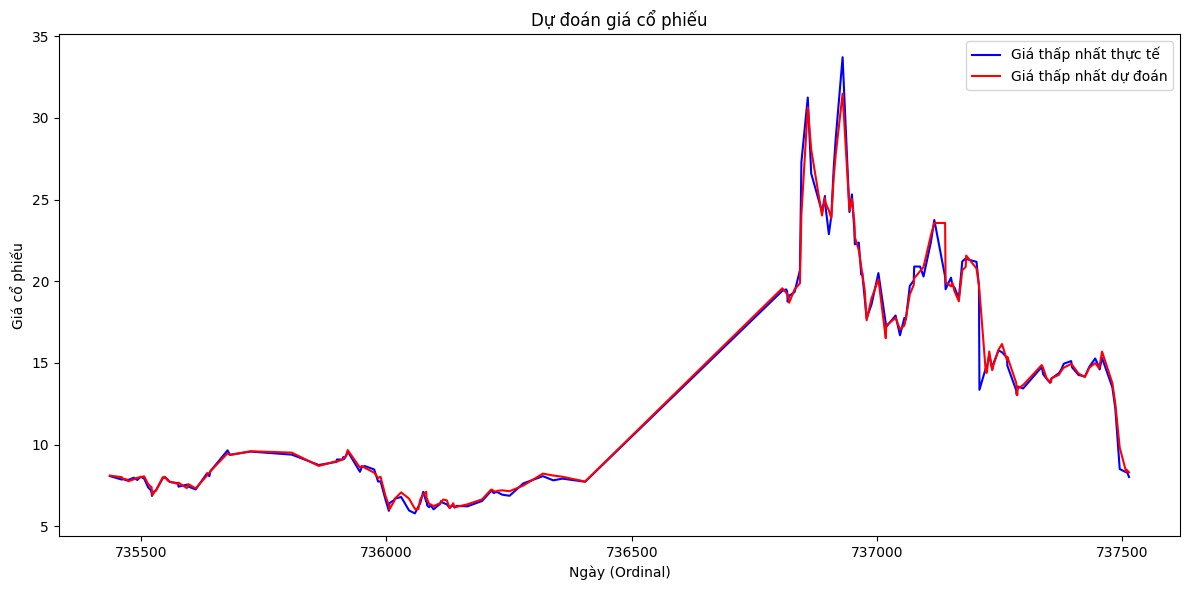

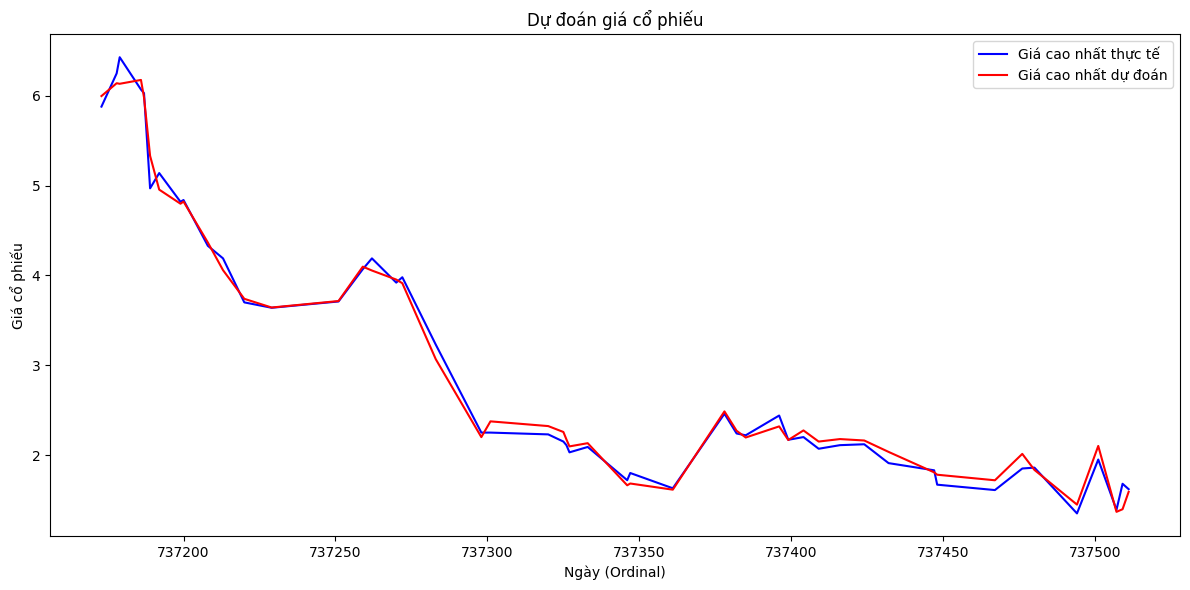

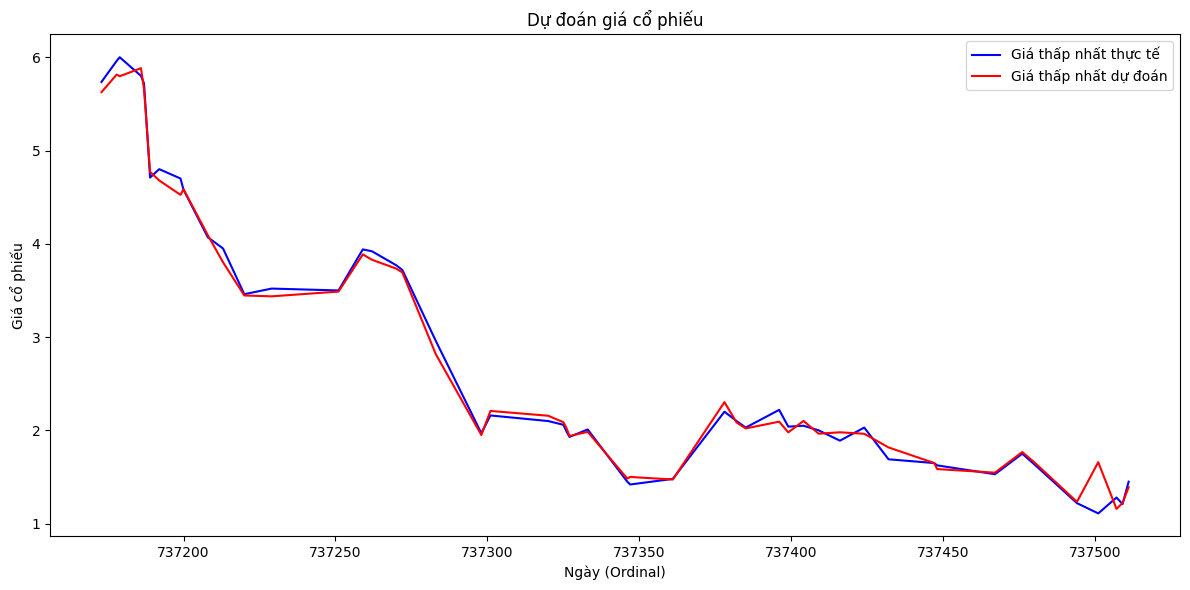

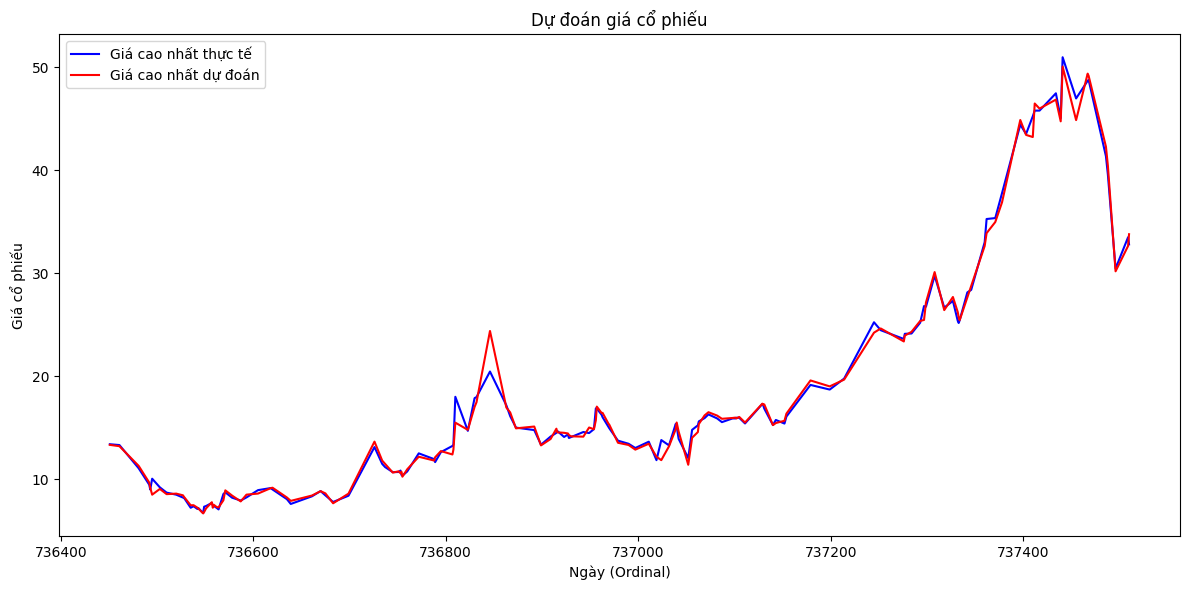

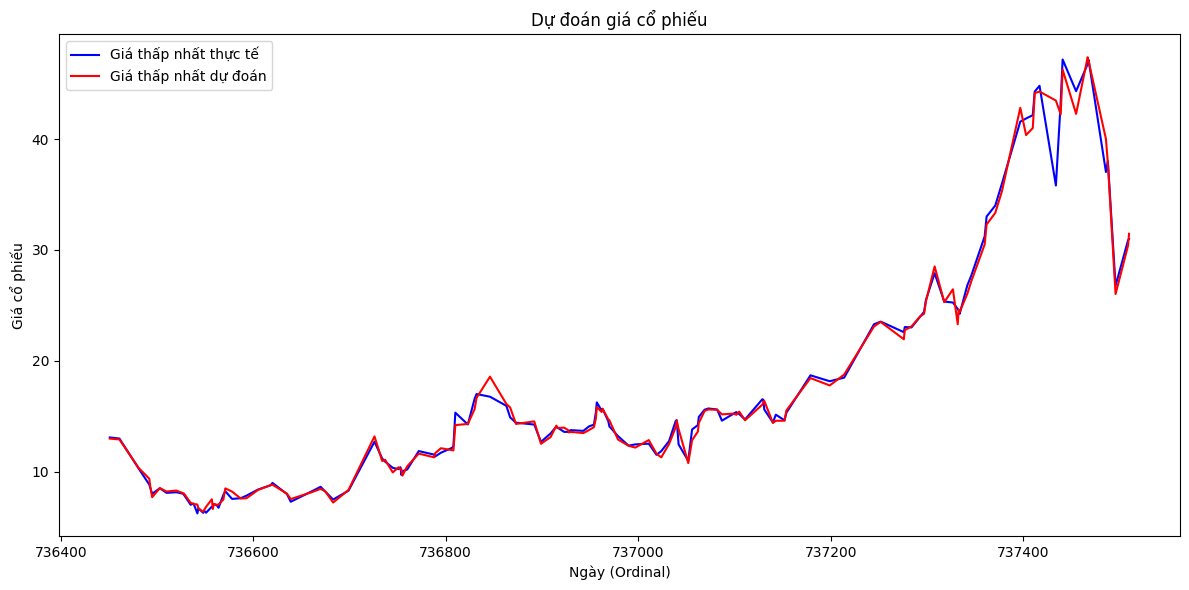

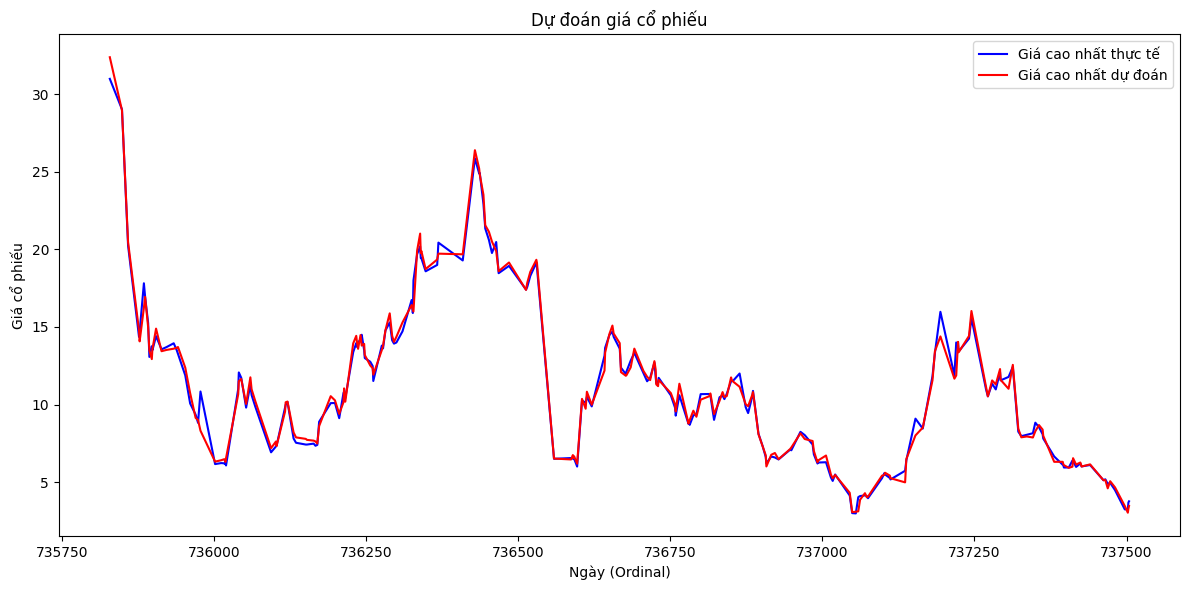

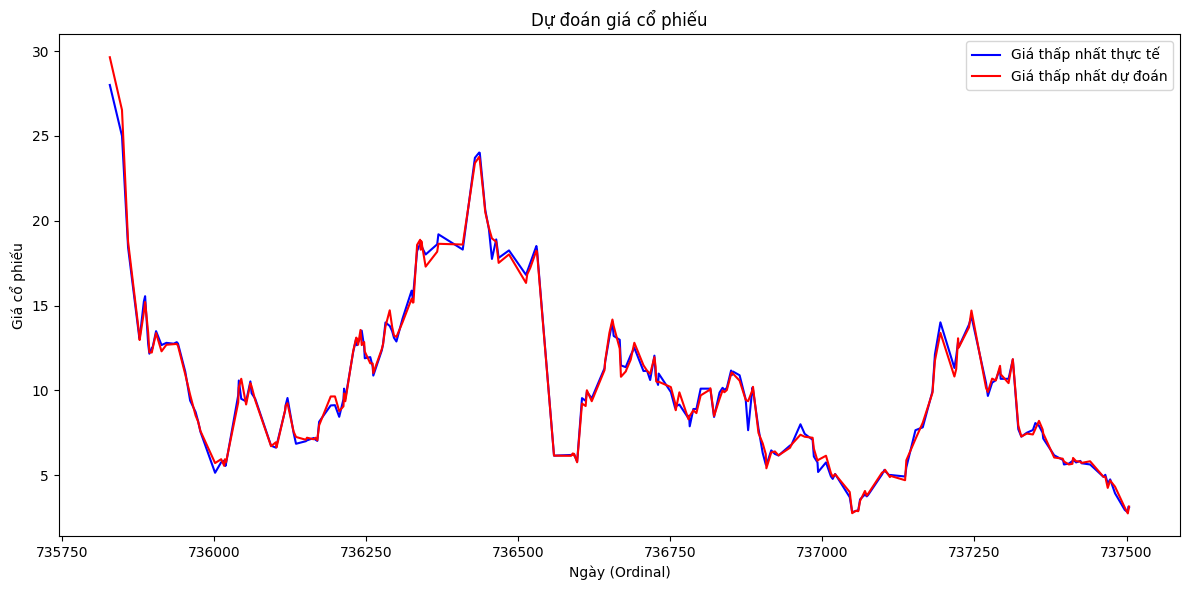

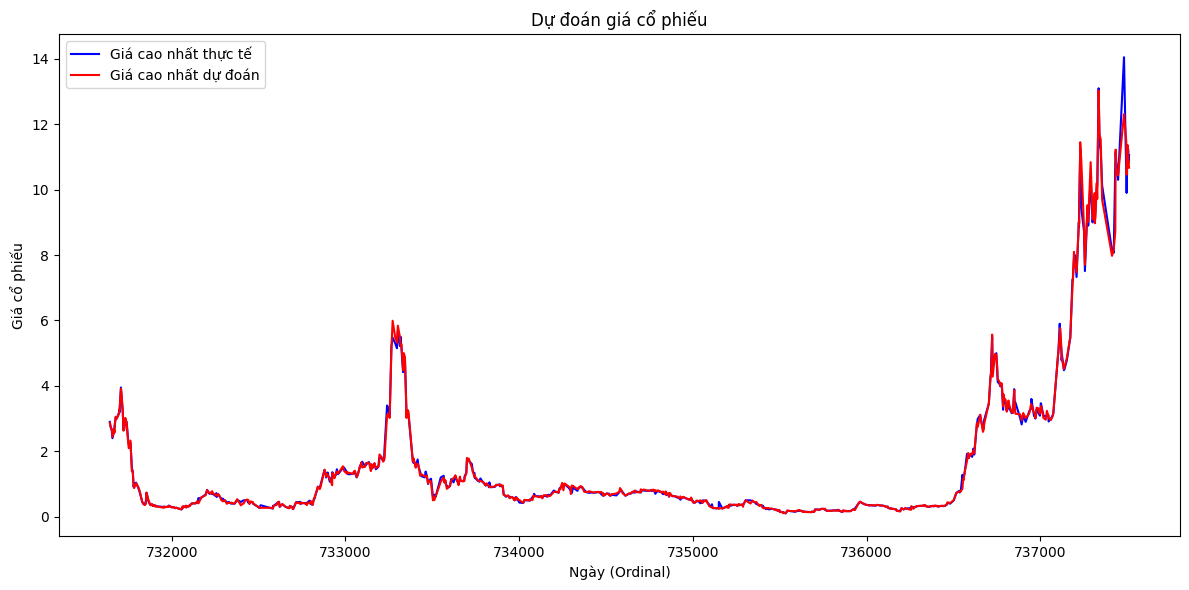

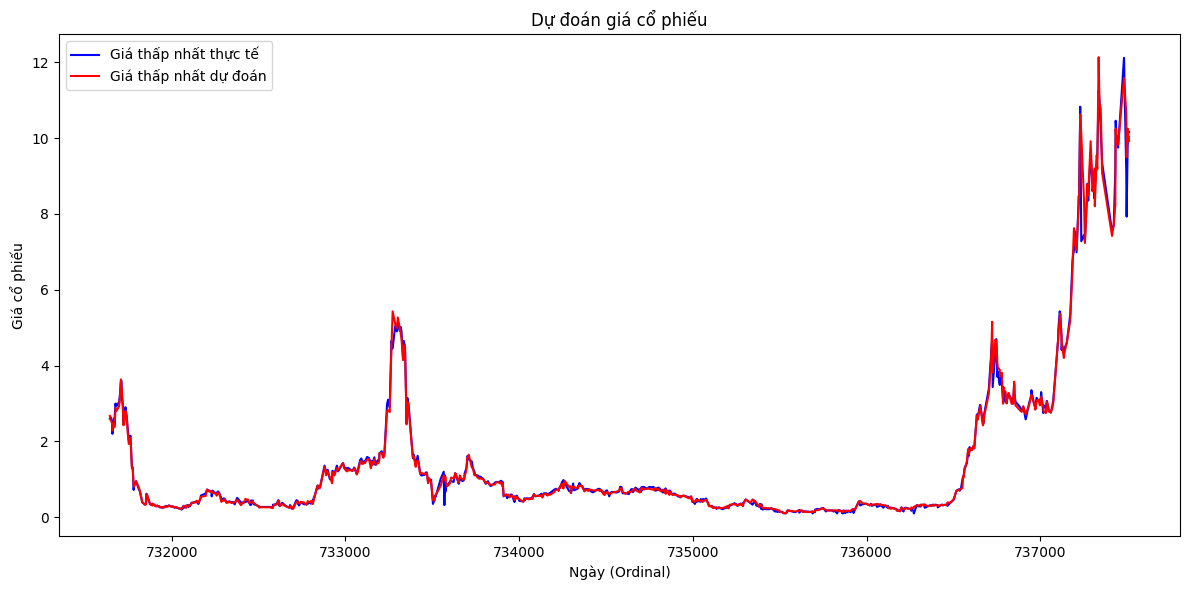

In [ ]:
i = 0
for prediction, set, df in zip(predictions, sets, data_frames):
    filename = f"prediction {df['file'][i] + str(i + 1)}.png"
    i += 1
    plot_high_predictions(set[1], prediction, set[3], 'data\high ' + filename)
    plot_low_predictions(set[1], prediction, set[3], 'data\low ' + filename)